# LangChain Agents Bootcamp - Financial Analysis with Gemini

Complete guide to building production-ready agents with memory, middleware, and streaming.

https://docs.langchain.com/oss/python/langchain/middleware/built-in

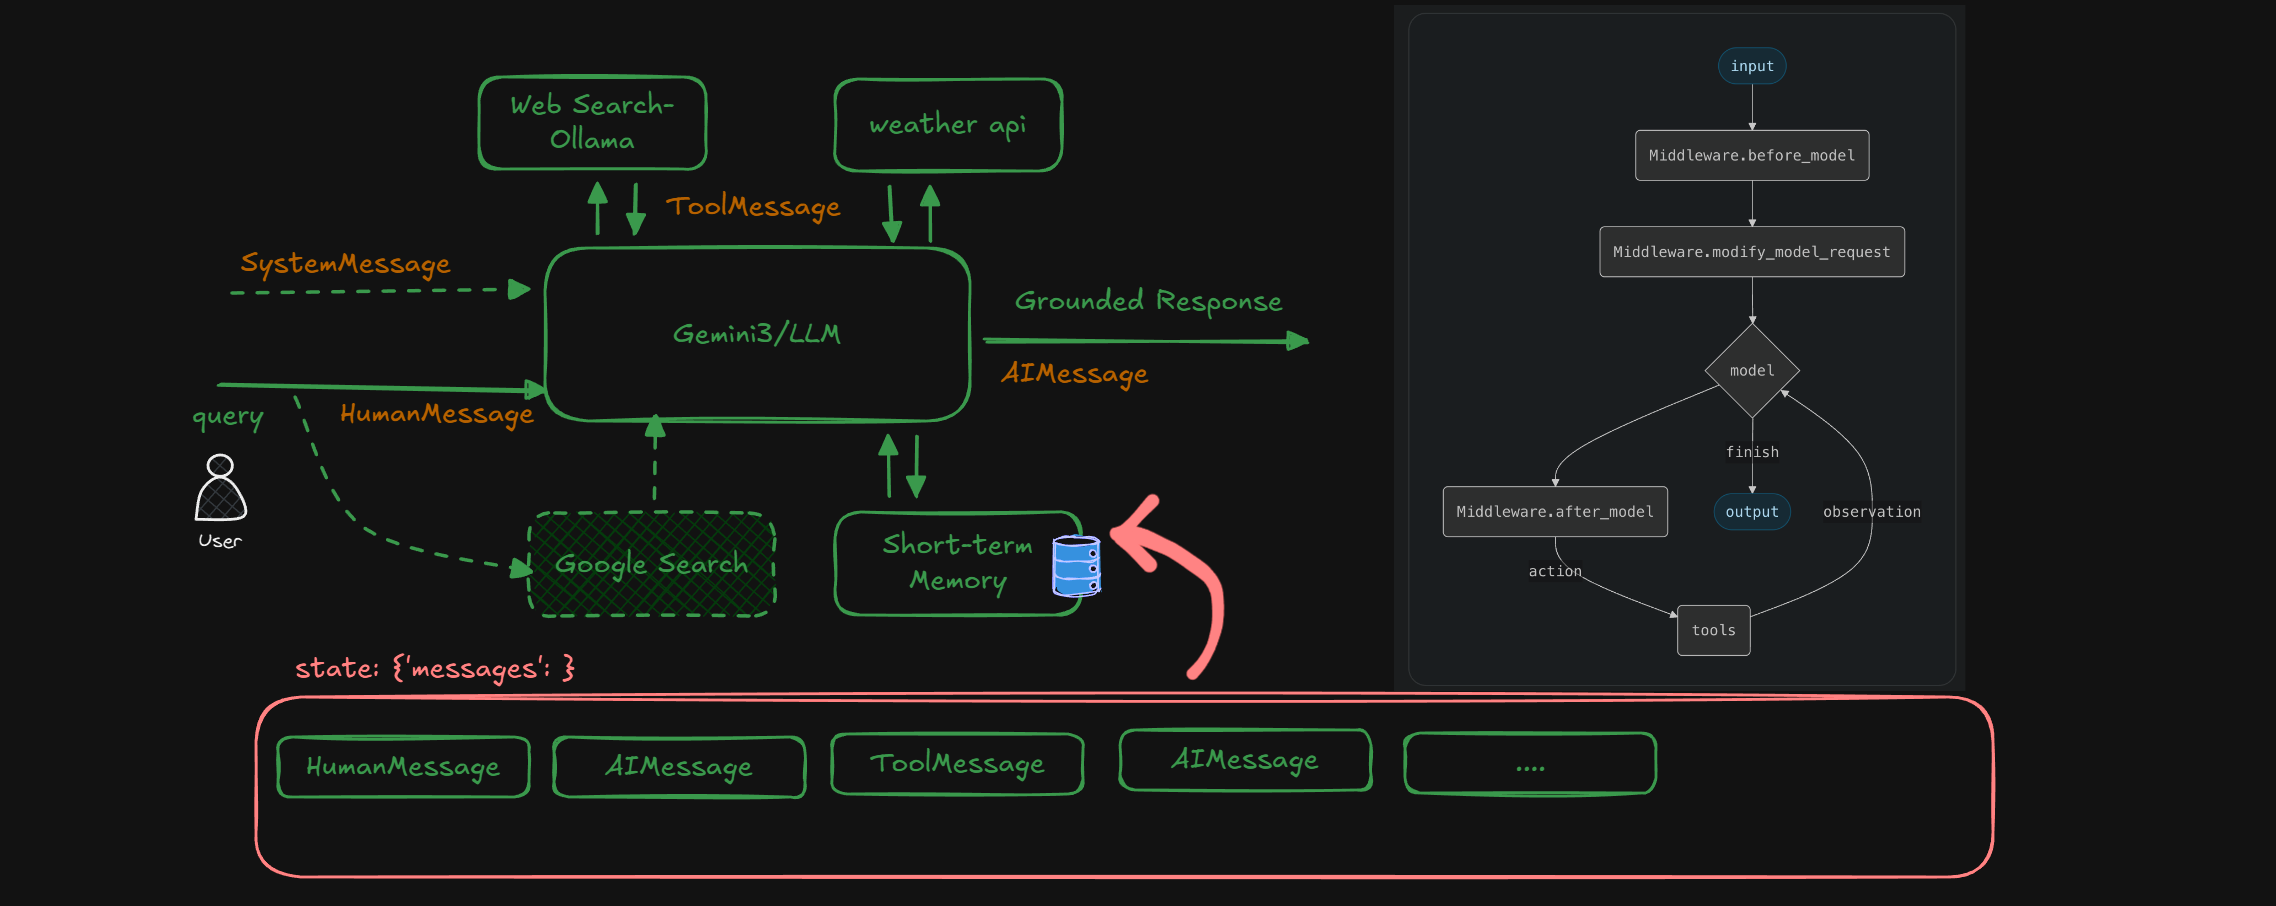

## Overview

This notebook covers:
- **Short-term Memory**: Persist conversation state with SQLite
- **Built-in Middleware**: Production patterns (summarization, limits, PII detection, todo tracking)
- **Structured Output**: Type-safe agent responses with Pydantic
- **Streaming Modes**: Real-time updates (`messages`, `updates`, `values`)

## Setup

Initialize model and tools for financial analysis.

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [28]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import create_agent
from langchain.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from scripts import base_tools

In [4]:
model = ChatGoogleGenerativeAI(model='gemini-2.5-flash') # gemini-3-pro-preview

In [96]:
system_prompt = "You are a financial analyst specializing in tech stocks.\nProvide data-driven analysis with clear insights. you have access to web_search tools and get_weather tools."

## 1. Basic Agent

Create a simple agent with tools but no memory.

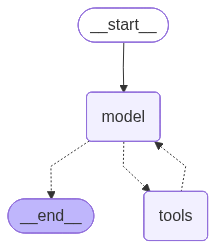

In [7]:
agent = create_agent(model=model,
                     tools=[base_tools.web_search, base_tools.get_weather],
                     system_prompt=system_prompt)

agent

In [8]:
query = "what's apple's current stock price?"
response = agent.invoke({'messages': [HumanMessage(query)]})

In [9]:
response

{'messages': [HumanMessage(content="what's apple's current stock price?", additional_kwargs={}, response_metadata={}, id='ea3baa20-a8ec-4482-b739-1c472190249b'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "Apple stock price"}'}, '__gemini_function_call_thought_signatures__': {'3dfc411c-f5c1-4be5-ba5d-dfe5fafd9529': 'CuwBAXLI2nxzI0UaOKoqv0YyjgtxvklDbjQRfzl12FaIWT5nHfJbX8MYz6Z0ech/wzEfEwoNzsipMXvegsi8orX41G3DAwtr21EgF2MO5tqwrJdn7786ytZP9DYa0na11gln2c3lT7uy87L5L0ft6/HvFRZXAAB15moKXoETodr37IBLXe4kssnUNqjUmxyyUAC/G+zCPVG5zKfLib7R40r3DkRNeaQZIips2cHBQ4cUqXqAvJLrj+HT+UCw9WF0IR8fN7BQoPpli9ga4PEtDLeqLlCyypkQhBVEIzZRhfBD+3kSTZgcUqf9tdyeWqw='}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--d0112fd7-de76-44c1-8823-8bb3c81c99b1-0', tool_calls=[{'name': 'web_search', 'args': 

In [10]:
query = "what's apple's current stock price? and what is the latest weather in Mumbai?"
response = agent.invoke({'messages': [HumanMessage(query)]})

In [11]:
response

{'messages': [HumanMessage(content="what's apple's current stock price? and what is the latest weather in Mumbai?", additional_kwargs={}, response_metadata={}, id='e084635f-b623-4d33-b855-c3fb169dac78'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Mumbai"}'}, '__gemini_function_call_thought_signatures__': {'08397d1f-d671-47fc-b975-816998b52ba1': 'CrcCAXLI2nxe4diWfPcSQIP/dw3aInYYi5LFO1HlpoJuhrjrX+PbzN905nnTq0pBEM2DAZ39xyMh/DgltHgEGdIqwMjvEbpX34xK8ogwHvtKw2+JDjHrece3OVqXQn0RPwWsmYFAfGbzFs0eQwY7eU4D4KkKIcvAq0iVuEdJdfrx4pVwEG1mXzp9frzqmASkzbxzTEFeg4XFA0ZTeLCcq7CBGtPnwddM4TaLHBgEgQHqcZCZsPFN503Iiio/PDRGSl4GyhRAm4Jv6Q2Ji5uj2LkfJGhO2St9FRnRreC7QZQMp3MSuexWPZg6tZqegXw25Fvv33pfKvu9Dv0q2oTrXPKOuUPBFzeWWAm/RpgrAGDN+qMskiPiXLTJuI2KR2eYIIZpO6mgWc/0l/BfMlVkupHXAGfcvGvYjuU='}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': 

In [15]:
print(response['messages'][-1].text)

Apple's current stock price is $277.89, with an after-hours price of $277.16 (as of December 8, 2025, 4:01 AM EST).

The latest weather in Mumbai is overcast, with a temperature of 34.2°C (93.6°F). It feels like 36°C (96.7°F), with 18% humidity and a Northwest wind at 7.6 kph (4.7 mph).


## 2. Short-term Memory with SQLite

Add conversation persistence using SQLite checkpointer. Agent remembers previous turns within a session.

In [16]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect("data/financial_agent.db", check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

In [17]:
agent_memory = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer = checkpointer)

In [21]:
config = {"configurable": {"thread_id": "memory_session"}}
response = agent_memory.invoke({'messages': [query]}, config=config)

In [22]:
response

{'messages': [HumanMessage(content="what's apple's current stock price? and what is the latest weather in Mumbai?", additional_kwargs={}, response_metadata={}, id='de3aaad5-ad11-4f58-be20-3c27dfd5e9a0'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Mumbai"}'}, '__gemini_function_call_thought_signatures__': {'200d4f68-b773-4bb9-bae2-00c705d2d5ad': 'Cv4CAXLI2nwF3L6aCwUgZnw3oNNh3wDiUObq5+K+cB739420p0rGpZaTPuJzVE/VxkT/LE+CzkKIa1aS0S7I8LuPvGTBOgLXtOkf6G/Ugg/iMQYwh9j/GsXR1KjfOvOvEpipPLsF2gQgOLvEhrqaNIefYwWCxvV5lkSQCXhAj0Fkx1F0AH4w9uBvgh/ZqbiBEx6p1mnGU+IKs4TDwKt9SCWDzZNn5zKv/OjH6AdtdLbcLg54acYwfiAgmRRtszVhPa3HWLLeund9wE9PwrbyiZcic31zaPm4Kh1LWEJ5zaq5vYQi5T29jI8TdDq37sIEKDwGHu2vxsanu14zGtqMBmuDVDGpY9NjWbvl4Xqwx+7d2XFzMy4F96HtwBlLFsGM4ZGhq+Tj0mJvKMVeHJbdH1m4dgVYURBwKL2v2lrPXKaW4steZNDUcvu1V0/jFq3Bd6AJIsh+X0S7Ou1CE3y3DkjAQpv5VJQPytCuxnt2PhzHmVgZ8aEzMZ8OfHgTCq6ZmA=='}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'saf

In [23]:
response = agent_memory.invoke({'messages': ["what is the latest US stock news"]}, config=config)

In [24]:
response

{'messages': [HumanMessage(content="what's apple's current stock price? and what is the latest weather in Mumbai?", additional_kwargs={}, response_metadata={}, id='de3aaad5-ad11-4f58-be20-3c27dfd5e9a0'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Mumbai"}'}, '__gemini_function_call_thought_signatures__': {'200d4f68-b773-4bb9-bae2-00c705d2d5ad': 'Cv4CAXLI2nwF3L6aCwUgZnw3oNNh3wDiUObq5+K+cB739420p0rGpZaTPuJzVE/VxkT/LE+CzkKIa1aS0S7I8LuPvGTBOgLXtOkf6G/Ugg/iMQYwh9j/GsXR1KjfOvOvEpipPLsF2gQgOLvEhrqaNIefYwWCxvV5lkSQCXhAj0Fkx1F0AH4w9uBvgh/ZqbiBEx6p1mnGU+IKs4TDwKt9SCWDzZNn5zKv/OjH6AdtdLbcLg54acYwfiAgmRRtszVhPa3HWLLeund9wE9PwrbyiZcic31zaPm4Kh1LWEJ5zaq5vYQi5T29jI8TdDq37sIEKDwGHu2vxsanu14zGtqMBmuDVDGpY9NjWbvl4Xqwx+7d2XFzMy4F96HtwBlLFsGM4ZGhq+Tj0mJvKMVeHJbdH1m4dgVYURBwKL2v2lrPXKaW4steZNDUcvu1V0/jFq3Bd6AJIsh+X0S7Ou1CE3y3DkjAQpv5VJQPytCuxnt2PhzHmVgZ8aEzMZ8OfHgTCq6ZmA=='}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'saf

In [29]:
for res in response['messages']:
    if isinstance(res, AIMessage):
        print(res.usage_metadata)

{'input_tokens': 234, 'output_tokens': 116, 'total_tokens': 350, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 84}}
{'input_tokens': 9873, 'output_tokens': 391, 'total_tokens': 10264, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 300}}
{'input_tokens': 9973, 'output_tokens': 64, 'total_tokens': 10037, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 46}}
{'input_tokens': 21723, 'output_tokens': 842, 'total_tokens': 22565, 'input_token_details': {'cache_read': 10010}}


## Built-in Middleware

## 3. Middleware: Summarization

Automatically summarize old messages when history grows too long.

**Use Case**: Long conversations that exceed context windows.

In [31]:
from langchain.agents.middleware import SummarizationMiddleware

In [46]:
agent_summary = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[
        SummarizationMiddleware(
            model=ChatGoogleGenerativeAI(model='gemini-2.5-flash'),
            trigger=[("messages", 15)],
            keep=("messages", 5)
        )
    ]
)

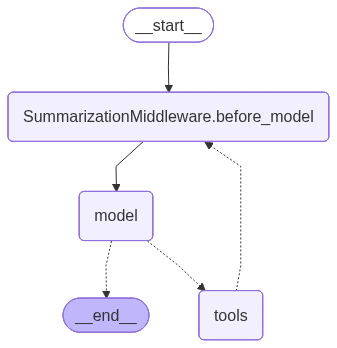

In [47]:
agent_summary

In [56]:
response = agent_summary.invoke({'messages': ['what is the stock price of Microsoft and Apple. What is the latest weather in Mumbai. What is the latest news on Asian Stock market?. Use the web search tool.']}, config=config)

In [57]:
response['messages'][0].pretty_print()

================================ Human Message =================================

Here is a summary of the conversation to date:

The assistant cannot provide real-time stock prices for Amazon, Microsoft, or Apple.
The assistant has provided the latest weather in Mumbai: 33.2°C (91.8°F), feels like 35.8°C (96.5°F), overcast, wind 17.3 kph (10.7 mph) from the Northwest, 19% humidity, 4 km (2 miles) visibility.
The assistant has provided sources for the latest news on the Asian Stock market: Reuters Asian Market Headlines (`https://www.reuters.com/markets/asia/`) and CNBC Asia Stock Markets (`https://www.cnbc.com/asia-markets/`).
The user continues to repeatedly ask for real-time stock prices, Mumbai weather, and Asian stock market news.


In [54]:
response['messages'][-1].text

"I cannot provide real-time stock prices for Microsoft and Apple, as web search results are not real-time and are primarily for informational purposes. However, based on the web search:\n\n**Microsoft (MSFT):**\n*   **After Hours:** 490.30 USD (-0.15%) as of 7:59 PM EST (Volume: 3,162,015)\n*   **Close:** 491.02 USD (+1.63%) (Volume: 18,335,129)\n*   **52-week range:** 344.79 - 555.45\n\n**Apple (AAPL):**\n*   **Last Price (delayed by 20 minutes):** 278.85 USD (+1.30) as of November 28, 2025 1:00 p.m. ET (Volume: 20.1M)\n*   **Day's Range (Yahoo Finance):** 275.27 - 280.38\n*   **52-week Range (Yahoo Finance):** 169.21 - 280.38\n\nPlease note that these stock prices are not live and are subject to change. For the most up-to-date stock information, please consult a real-time financial data provider.\n\n**Weather in Mumbai:**\nThe current temperature in Mumbai is 33.2°C (91.8°F) and it feels like 35.8°C (96.5°F). The conditions are overcast with a wind speed of 17.3 kph (10.7 mph) from t

In [58]:
response

{'messages': [HumanMessage(content='Here is a summary of the conversation to date:\n\nThe assistant cannot provide real-time stock prices for Amazon, Microsoft, or Apple.\nThe assistant has provided the latest weather in Mumbai: 33.2°C (91.8°F), feels like 35.8°C (96.5°F), overcast, wind 17.3 kph (10.7 mph) from the Northwest, 19% humidity, 4 km (2 miles) visibility.\nThe assistant has provided sources for the latest news on the Asian Stock market: Reuters Asian Market Headlines (`https://www.reuters.com/markets/asia/`) and CNBC Asia Stock Markets (`https://www.cnbc.com/asia-markets/`).\nThe user continues to repeatedly ask for real-time stock prices, Mumbai weather, and Asian stock market news.', additional_kwargs={}, response_metadata={}, id='2eb32c65-448d-42f4-a61c-aca54cec8780'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "latest news on Asian Stock market"}'}, '__gemini_function_call_thought_signatures__': {'e7b41d93-

## 4. Middleware: Model and Tool Call Limit

Limit the number of model calls per request to prevent runaway costs.

**Exit Behaviors**: `"end"` (stop) or `"continue"` (proceed without model)

In [59]:
from langchain.agents.middleware import ModelCallLimitMiddleware
from langchain.agents.middleware import ToolCallLimitMiddleware
from langchain.agents.middleware import ModelFallbackMiddleware

In [ ]:
agent_limit = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[
        SummarizationMiddleware(
            model=ChatGoogleGenerativeAI(model='gemini-2.5-flash'),
            trigger=[("messages", 15)],
            keep=("messages", 5)
        ),
        ModelCallLimitMiddleware(run_limit=2, exit_behavior="end"),
        ToolCallLimitMiddleware(run_limit=2, exit_behavior='continue'),
        ModelFallbackMiddleware(ChatGoogleGenerativeAI(model='gemini-3-pro-preview'))
    ]
)

In [69]:
config = {'configurable': {'thread_id': 'limit_session'}}
response = agent_limit.invoke({'messages': ['what is the total distance between earth and moon. what is the latest news on trump. what is the latest weather of London?']}, config)


In [70]:
response

{'messages': [HumanMessage(content='what is the total distance between earth and moon. what is the latest news on trump. what is the latest weather of London?', additional_kwargs={}, response_metadata={}, id='aa4599f2-87b9-44d7-8037-e97bbd9de07e'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "London"}'}, '__gemini_function_call_thought_signatures__': {'3f0fb8fa-29d0-49c7-88a9-b511f0f089c9': 'CrMDAXLI2nxyGMpGwv/zCyRqYxbgqULxam9pajFpBwaNs59JogVtZdCnKj3dNCUFX2LFB14c8+l7zBTwCGzGG1t1fFf2+1nntWrxot96gWsjmsFbiuHS2UWZok0e0bOlJonBjpo4mhfItOa0TGyhPugHM1vPc5zrYRB7P8azvApxZXBbrJ9nPg9HXc6OvPZ6O2+8IMFz/HBIC2pwEvoQP6oo4hkRSjaAfHweOvilQyD6c6TQA9Ovvh0dinhKM1ETrPix5K/Sscx6Mk2XThL4FILJ3Ess2hZqi127LDZWnByS7vxQTpNwrEHOTuUe9oIAjy8uMwdIFMfeF/9DJjF6R+ZMMBNvGcEJqQlmKUOd67lESwJI+yY/WAlVKDZXYfYt515ABlA3hT0lmc2VD0bjOJRTrU/Kuvpy2X7BDM5zJJfJFFYiB6RtDURtACfa2YqFF5oySGrF43d5vmQAIj0HSCQocwDqorI8Lce8O7NRP10ssMXVJb0yKaTYZ8iTD2jbgnnhSsgy496Fa/4e+9Dv70YIZi

In [71]:
response = agent_limit.invoke({'messages': ['tell me 3 facts about the earth']}, config)
response

{'messages': [HumanMessage(content='what is the total distance between earth and moon. what is the latest news on trump. what is the latest weather of London?', additional_kwargs={}, response_metadata={}, id='aa4599f2-87b9-44d7-8037-e97bbd9de07e'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "London"}'}, '__gemini_function_call_thought_signatures__': {'3f0fb8fa-29d0-49c7-88a9-b511f0f089c9': 'CrMDAXLI2nxyGMpGwv/zCyRqYxbgqULxam9pajFpBwaNs59JogVtZdCnKj3dNCUFX2LFB14c8+l7zBTwCGzGG1t1fFf2+1nntWrxot96gWsjmsFbiuHS2UWZok0e0bOlJonBjpo4mhfItOa0TGyhPugHM1vPc5zrYRB7P8azvApxZXBbrJ9nPg9HXc6OvPZ6O2+8IMFz/HBIC2pwEvoQP6oo4hkRSjaAfHweOvilQyD6c6TQA9Ovvh0dinhKM1ETrPix5K/Sscx6Mk2XThL4FILJ3Ess2hZqi127LDZWnByS7vxQTpNwrEHOTuUe9oIAjy8uMwdIFMfeF/9DJjF6R+ZMMBNvGcEJqQlmKUOd67lESwJI+yY/WAlVKDZXYfYt515ABlA3hT0lmc2VD0bjOJRTrU/Kuvpy2X7BDM5zJJfJFFYiB6RtDURtACfa2YqFF5oySGrF43d5vmQAIj0HSCQocwDqorI8Lce8O7NRP10ssMXVJb0yKaTYZ8iTD2jbgnnhSsgy496Fa/4e+9Dv70YIZi

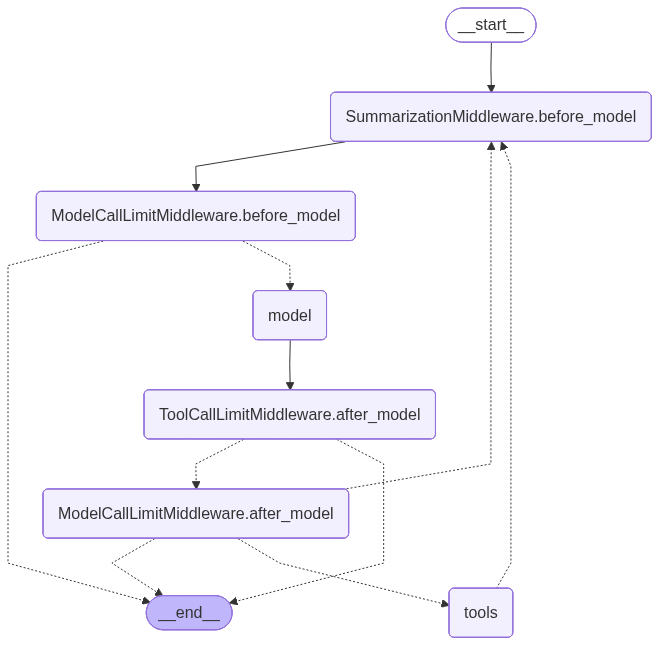

In [73]:
agent_limit

## 5. Middleware: Guardrails and PII Detection

Automatically detect and redact/mask personally identifiable information.

**Strategies**: `"redact"` (remove), `"mask"` (replace with ***), `"block"` (prevent request)

In [74]:
from langchain.agents.middleware import PIIMiddleware


In [ ]:
agent_pii = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[
        PIIMiddleware("api_key", detector=r"sk-[a-zA-Z0-9]{32}", strategy="block"),
        PIIMiddleware("email", strategy="redact", apply_to_input=True),
        PIIMiddleware("credit_card", strategy="mask", apply_to_input=True),
        PIIMiddleware("url", strategy="redact", apply_to_input=True)
    ])

In [79]:
config = {'configurable': {'thread_id': 'pii_session'}}

response = agent_pii.invoke({'messages': [HumanMessage('Hi, my name is laxmi kant. here is my email info@kgptalkie.com')]}, config=config)

In [80]:
response

{'messages': [HumanMessage(content='Hi, my name is laxmi kant. here is my email [REDACTED_EMAIL]', additional_kwargs={}, response_metadata={}, id='e8d83bcb-7abe-4b69-ba3a-5e8af700554a'),
  AIMessage(content=[{'type': 'text', 'text': "Hello Laxmi Kant, it's a pleasure to meet you. As a financial analyst specializing in tech stocks, I'm here to provide you with data-driven analysis and clear insights. How can I assist you today regarding tech stocks?", 'extras': {'signature': 'Cp8CAXLI2nyjogamvGPGAv1MhcSzOEYWw7m+hAYE/pBELZ1D7rBsKFpsLYKOFkgMMlFBnvgObCqaf/Pc3fr5kkYuRoCHWpc2QulG7RrP6gdubk735+hvZxA/F0wIFje55Vy0W+tGrqUSYb74TKUv9rThZWinjrSytwSvBunpCNm5rA3sctpZJgBKiicsaScV2MPlRVGe0Cy6M+ob745SdVkahdckmmKVaSLmnBXyHDBEXr7kZwMiN6sICOodVjOjcmoCs3nBrM38dfCgfWlPbIUHKQf+Xy04t/FAwCbK1xl99FIKYftlfLktNmQ24ZDp8BIElJN7Lr4aMmXL1oPlMuDuZhA+7LB9iGhShxlz8ktDbwCngVZL5sTomOE9p0AlVug='}}], additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP'

In [81]:
response = agent_pii.invoke({'messages': 
                             [HumanMessage('Hi, my name is laxmi kant. here is my email info@kgptalkie.com. my website is https://kgptalkie.com')]}, config=config)

In [82]:
response

{'messages': [HumanMessage(content='Hi, my name is laxmi kant. here is my email [REDACTED_EMAIL]', additional_kwargs={}, response_metadata={}, id='e8d83bcb-7abe-4b69-ba3a-5e8af700554a'),
  AIMessage(content=[{'type': 'text', 'text': "Hello Laxmi Kant, it's a pleasure to meet you. As a financial analyst specializing in tech stocks, I'm here to provide you with data-driven analysis and clear insights. How can I assist you today regarding tech stocks?", 'extras': {'signature': 'Cp8CAXLI2nyjogamvGPGAv1MhcSzOEYWw7m+hAYE/pBELZ1D7rBsKFpsLYKOFkgMMlFBnvgObCqaf/Pc3fr5kkYuRoCHWpc2QulG7RrP6gdubk735+hvZxA/F0wIFje55Vy0W+tGrqUSYb74TKUv9rThZWinjrSytwSvBunpCNm5rA3sctpZJgBKiicsaScV2MPlRVGe0Cy6M+ob745SdVkahdckmmKVaSLmnBXyHDBEXr7kZwMiN6sICOodVjOjcmoCs3nBrM38dfCgfWlPbIUHKQf+Xy04t/FAwCbK1xl99FIKYftlfLktNmQ24ZDp8BIElJN7Lr4aMmXL1oPlMuDuZhA+7LB9iGhShxlz8ktDbwCngVZL5sTomOE9p0AlVug='}}], additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP'

## 6. Middleware: Todo List

Track and manage multi-step tasks within the agent.

In [83]:
from langchain.agents.middleware import TodoListMiddleware

In [97]:
system_prompt

'You are a financial analyst specializing in tech stocks.\nProvide data-driven analysis with clear insights. you have access to web_search tools and get_weather tools.'

In [98]:
agent_todo = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[TodoListMiddleware()]
)

In [101]:
config = {'configurable': {'thread_id': 'todo_session_1'}}

response = agent_todo.invoke(
    {'messages': [HumanMessage("analyze the apple revenue and compare it with competitors")]},
    config=config
)

In [102]:
response

{'messages': [HumanMessage(content='analyze the apple revenue and compare it with competitors', additional_kwargs={}, response_metadata={}, id='5d03d32c-f9e5-4410-859f-76aff3d70d41'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'MALFORMED_FUNCTION_CALL', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--c93d80bc-0f6c-44cb-9046-3d0d68310762-0', usage_metadata={'input_tokens': 1410, 'output_tokens': 0, 'total_tokens': 1410, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='analyze the apple revenue and compare it with competitors', additional_kwargs={}, response_metadata={}, id='81cf9a31-40b5-4cc7-a424-87816fc9d02b'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_todos', 'arguments': '{"todos": [{"status": "in_progress", "content": "Identify Apple\'s main competitors."}, {"status": "pending

In [105]:
print(response['messages'][-1].text)

## Apple's Revenue Performance Against Key Competitors

As a financial analyst specializing in tech stocks, I've conducted a data-driven analysis of Apple's latest revenue figures and compared them with its primary competitors: Alphabet (Google), Microsoft, and Samsung Electronics.

### Key Findings:

Here's a summary of the latest reported quarterly revenues for each company (all periods ending around September 2025):

*   **Apple (Q4 2025):** **$102.5 billion** (up 8% year-over-year)
    *   *Annual Fiscal 2025 Revenue:* $416 billion (up 6% over 2024)
*   **Alphabet (Google) (Q3 2025):** **$102.3 billion** (up 16% year-over-year)
*   **Microsoft (FY26 Q1):** **$77.7 billion** (up 18% year-over-year)
*   **Samsung Electronics (Q3 2025):** Approximately **$61.61 billion** (KRW 86.1 trillion, converted at 1 KRW = 0.00071586443 USD)

### Analysis:

1.  **Top-Line Revenue Powerhouse:** Apple continues to demonstrate immense revenue-generating capability, with its latest quarter bringing i

## 7. Streaming: Messages Mode
Three streaming modes for real-time agent updates:
- **`messages`**: Stream individual messages as they're generated
- **`updates`**: Stream state updates after each step
- **`values`**: Stream complete state values

In [108]:
config = {'configurable': {'thread_id': 'stream_session'}}
for chunk in agent.stream({'messages':['tell me about the apple news']}, stream_mode='messages', config=config):
    print(chunk)
    print("------\n")

(AIMessageChunk(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "Apple Inc. news"}'}, '__gemini_function_call_thought_signatures__': {'09879ae3-1984-4a2f-805f-7755972607d6': 'CikBcsjafNmX3pvHVwXD2b/tS3CYVuywTPlsipSH3nOM4K1VUKuo3oe3ogp+AXLI2nygdUOWFZcF0geQW9e2kg+HHGxdLQeHb5zMLdAC9I5H1sbHipjvntRgEUNN/I0YccfVbQBgK1OBFcyNrnQztkXz5CEuqPEb6SbO8JCgIAbd7yWbPB+fTiZT871l4wy68M6qKqtYTjVqYaGhfiYGHjTSAExGtMFvx1wMCvEBAXLI2nypWGND7RR2sPh6vR9VfeReZcuizaRms6/3zYRvjl6seg7xa6kAO2LqHQNCtuEqUsy9iKhWRh38mq2FpXSXVFzi/ivTMqZgxU8SikPkmQ0r9Jua2uTlUCcudqw8WNyPe+xWQ/q3nqbvkIuxcJD+OdKMeiv/vgbYyt25B4000uo+FriJdl7CQ6kPEOrVvJcFYXX+a2geqTYKqd+E8zRath841zH8PecNPhcL7q8NRZ03UT9rW6ApRgecYKFX/N34Ot9jTRQaTdQpCYj7jDUL/FmtUC+bv0h8u9i4/tHweiZOZfDQXgcIf+wWmmwuIApSAXLI2nwYjTczKHdHxo7hf2MYAMQ0QI2ZUNyLcn716CX1fYRgALqPJMtSIqqykNg15JL+6oil6/xd1yf5JDN5XXr+Ywv8jdR1vVjMd+hBX77nLw=='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'mode

In [109]:
config = {'configurable': {'thread_id': 'stream_session_1'}}
for chunk in agent.stream({'messages':['tell me about the apple news']}, stream_mode='updates', config=config):
    print(chunk)
    print("------\n")

{'model': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "Apple Inc. news"}'}, '__gemini_function_call_thought_signatures__': {'03dd9562-ac56-41d7-916a-15e35ff462f0': 'CpwDAXLI2nyAU6UZup6V1petp3R96DHDkFcCTQfW9j2T/iNpTmaNWLdc7c7L6ejUUV6v8Nisj5WqneB5BymRBpC3iWYg14QEeSYCJ0haos5H5zBazuXEkXJ4DtR4w6PYJudfxf6qd+5YbjQRAioeTnfkGo4+EhsvEjwNB9Qs45kVyS2bEiV7Iu3KhuFevMIjA76MSydT2CtuE9oRjLvW31x2+TQmGV1ZczyndK0timi3EA1OAlCn2rsuhlTZBof85HAiPJBEfVml3fTDUA1QmF7qiFHMx+3szabAcrNkJN59CTAa3Kp4TJtu7VuxmobToySmPnO2wpvtitSYLR+shp91h+EclxZ++0TBFxeqB9ccXil8lqX3zVYSvAuhaFOeOoxcsU5grSiCpOXwU4Ecyd5DMhZ/S64503RKSiSF5aa3pYYVhoeIK1vDPT9ufYHvsxnLC7yS6tdd3R45FiU3bBaIktLz9CNxHrcVROG7f9h2ZHArSeFhikTAXDnW/zmh03Wlef3N5bYMLSWWWoOYLepxgkgsqakZ46C/4a/lrQ=='}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id

In [112]:
config = {'configurable': {'thread_id': 'stream_session_2'}}
for chunk in agent.stream({'messages':['tell me about the apple news']}, stream_mode='values', config=config):
    print(chunk)
    print("------\n")

{'messages': [HumanMessage(content='tell me about the apple news', additional_kwargs={}, response_metadata={}, id='e0ccba3e-c53d-432e-8896-b45b9491c0a3')]}
------

{'messages': [HumanMessage(content='tell me about the apple news', additional_kwargs={}, response_metadata={}, id='e0ccba3e-c53d-432e-8896-b45b9491c0a3'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "Apple Inc. news"}'}, '__gemini_function_call_thought_signatures__': {'76d3317a-ebeb-496a-ad6c-9f41870a064c': 'CvkBAXLI2nx9obbzryp56S2wAw+IEhbt4f4n/ZEyLA/Xr5DZNDFxE7naNkw0nr2UhzX6THYR/LTDy0YAaJ9VANlMb0hYggMoTBlhjcwmJqknSv73uzB+RBH/FoOflb74J9rrUdaS+JBM3buHqd9Kwi1j8pAARnbSWttW7uO4gUNzNhe0lUCiFD8jSQ2Dd8Rienw0aL9pYNnJlOs3FHpAAxg0qENHZ2bOs8sP5BzvKwVD4e5a9TriEZ4/qX75xLZhtffJTJOIiSBx9lqNfa+2FqSj4AkBSZeHh3dXvzMBLumLs20zpoMQ1Mx0vlYPx707d4sdDpL07zwzo8XY'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gem

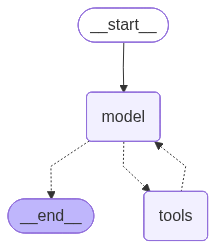

In [106]:
agent

## 8. Structured Output

Return type-safe Pydantic models from agent responses.

In [115]:
from pydantic import BaseModel, Field
from typing import Optional

In [116]:
class FinancialAnalysis(BaseModel):
    company: str = Field (description="Company Name")
    stock_symbol: str = Field (description="Company Stock Symbol")
    current_price: Optional[str] = Field (description="Company's current stock price")
    analysis: str = Field (description="Company's brief analysis")
    recommendation: str = Field (description="What is recommendation? Buy/Hold/Sell")

In [117]:
agent = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    response_format = FinancialAnalysis
)

In [118]:
response = agent.invoke({'messages': [HumanMessage('Analyze the apple stock')]})

In [119]:
response

{'messages': [HumanMessage(content='Analyze the apple stock', additional_kwargs={}, response_metadata={}, id='8a764ab2-f821-4564-86ab-4c39c0ee6a9c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "Apple stock analysis AAPL"}'}, '__gemini_function_call_thought_signatures__': {'6427bb89-91ce-4431-b327-69cd3414a77b': 'CuwCAXLI2nxCCrdJ0kgJCjSf8eyBnpXIZivoquc3fX6JMG6n8oxJoyxFclpJ9V+yLV3b2zkZjS1z8XUqczcjbToZhNjI8cejUpTnnYraDXmRm8avrQ0g/1Sxx/5IJgzaziro6RuYBCVsrLAA1S3GvhGMXQrT/Dh3QbiGJ/uWD4tJEG1yTfPuLjrvWpOLwaulOdKjh/U6DbQiU3ppY8b2YuKZYEPvgEBGEzEkJyBtIh5/P0Y0VVkAnI8k2GAPNcqk5BACVU7u3fUFiaP3ItCx6jjpYVQLE6yNXaDXXUlXHZpT8uBCBV+JSH4JKke2K6HjVcqXuxJu9I/BP8YuOpBcMP6PlVJWfzgQ+YBEiP8cXO8rFOVmwjj+KZYng1+Jdvl9fkUVr2RCaxmjlTj1XQX9WT8XGWlKL1nHYEU+NDemV7wDzoq6JryXh8mIr3Eh5Ulpzt7cigoKoU5LLGbY16XGVfYXk3KV2XPVZruQ54ttaQ=='}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemi

In [121]:
response['structured_response'].model_dump()

{'company': 'Apple Inc.',
 'stock_symbol': 'AAPL',
 'current_price': '$283.10',
 'analysis': "Apple Inc. (AAPL) currently trades at $283.10 with a market capitalization of $4.18 trillion. The company exhibits a strong ecosystem of hardware, software, and services, contributing to customer loyalty and robust profitability. Its P/E ratio of 42.96 is higher than the market average but lower than the Computer and Technology sector average. Projected earnings growth stands at a healthy 12.64%, and Apple has a strong track record of dividend increases (14 consecutive years) with a sustainable payout ratio of 13.92%. \\n\\nAnalyst consensus is a 'Moderate Buy,' however, the average price target of $278.22 suggests limited immediate upside from the current price. Valuation metrics like the PEG Ratio (2.62) and Price to Book Value (74.70) indicate that the stock might be overvalued. Recent developments include a change in AI leadership and discussions around diversifying chip suppliers. Notably